# Base de données répertoriant les indicateurs de délinquance et de criminalité (1996-2022 en France)

(NB : Les liens hypertextes présent dans ce markdown et les suivant renvoient aux sites internet sur lesquelles les tableaux de données ont été téléchargées et ne correspondent pas aux URL de téléchargement, l'exécution des cellules de code permet de télécharger automatiquement les jeu de données)

Nous avons récupéré, grâce à l'open data du ministère de l'intérieur ([ici](https://www.data.gouv.fr/fr/datasets/chiffres-departementaux-mensuels-relatifs-aux-crimes-et-delits-enregistres-par-les-services-de-police-et-de-gendarmerie-depuis-janvier-1996/)) les données relatives aux crimes et délit enregistrés dans chaque département et en France entre janvier 1996 et août 2022. Ce jeu de données a été produit successivement par le Ministère de l'Intérieur puis par le SSMSI depuis sa création en 2014. 

Issu directement des applications informatiques de gestion, il n'est pas retraité et reste assez brut. Entre autre, il ne nous donne accès qu'au nombre d'infractions (classées par type) par département, nous l'avons donc complété avec des données d'estimation de population pour obtenir des taux d'infractions plutôt que des chiffres bruts. Nous avons ensuite ajoutée à notre base de données d'indices de localisation pour nous permettre de réaliser des représentations géographiques dans notre partie de statistiques descriptives.

### Récupération et nettoyage des données du Ministère de l'Intérieur relative aux crimes et délits


In [1]:
import requests
import pandas as pd
import geopandas as gpd
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
# URL de téléchargement du fichier
url = "https://static.data.gouv.fr/resources/chiffres-departementaux-mensuels-relatifs-aux-crimes-et-delits-enregistres-par-les-services-de-police-et-de-gendarmerie-depuis-janvier-1996/20221031-102847/tableaux-4001-ts.xlsx" 

# Dossier de destination pour enregistrer le fichier téléchargé
dossier_destination = "data_police"
os.makedirs(dossier_destination, exist_ok=True)

# Chemin du fichier téléchargé
fichier_telecharge = os.path.join(dossier_destination, "fichier.xlsx")

# Téléchargement du fichier
print("Téléchargement en cours...")
response = requests.get(url, stream=True)
with open(fichier_telecharge, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
print("Téléchargement terminé:", fichier_telecharge)

# Chargement des onglets du fichier Excel en DataFrames
print("Chargement des onglets dans des DataFrames...")
data = pd.read_excel(fichier_telecharge, sheet_name=None)  # `sheet_name=None` charge tous les onglets

# Fusion des onglets dans un unique DataFrame avec une colonne pour identifier le département (ou la zone)
données_police = pd.concat(
    [df.assign(Zone=nom_onglet) for nom_onglet, df in data.items()],
    ignore_index=True
)

# Suppression du fichier téléchargé 
os.remove(fichier_telecharge)
print("Fichier téléchargé supprimé.")

Téléchargement en cours...
Téléchargement terminé: data_police/fichier.xlsx
Chargement des onglets dans des DataFrames...
Fichier téléchargé supprimé.


On sépare notre premier jeu de données (données police) en deux pour obtenir une base de données départementale et une base nationale.


In [4]:
# Données pour la france entière
df_france_court = données_police[données_police['Zone'].isin(['France_Entière', 'France_Métro'])]

In [5]:
# Données départementales
df_dep_court = données_police[~données_police['Zone'].isin(['France_Entière', 'France_Métro'])]

Le format des tableaux de données actuel indique les dates sur une ligne (voir ci-dessous). 

| Index  | Libellé | Zone | _2022_08 | _2022_07 | ... | _1996_01 |
|-----------|----------|----------|----------|----------|----------|----------|
| Type 1    | Libellé  1 | France | Valeur 1 | Valeur 3 | Valeur 5 | Valeur 8 |
| Type 2    | Libellé  2 | France | Valeur 2 | Valeur 4 | Valeur 6 | Valeur 9 |

Nous préférions avoir une colonne indiquant les dates car il nous semblait plus simple de filtrer par date et d'ajouter de nouvelle colonnes d'information ainsi (exemple ci-dessous).

| Index | Libellé | Zone | Date |
|-------|---------|------|------|
| Type 1 | Libellé 1 | Zone a | _2022_08 |
| Type 2 | Libellé 2 | Zone a | _2022_08 |
| ... | ... | ... | ... |
| Type 1 | Libellé 1 | Zone f | _2012_05 |
| ... | ... | ... | ... |
| Type 34 | Libellé 34 | Zone z | _1996_01 |

Nous avons donc restructurer les deux tableaux de données (df_france_court et df_dep_court) en format long.


In [6]:
# Transformer le tableau (échelle nationale) en format "long"
df_france = df_france_court.melt(id_vars=['Index', 'libellé index', 'Zone'],  # Colonnes fixes
                  var_name='Date',  # Nom pour la colonne de dates
                  value_name='Nombre')  # Nom pour la colonne des valeurs

In [7]:
# Transformer le tableau (échelle départementale) en format "long"
df_dep = df_dep_court.melt(
    id_vars=['Index', 'libellé index', 'Zone'],  # Colonnes fixes
    var_name='Date',  # Nom pour la colonne de dates
    value_name='Nombre'  # Nom pour la colonne des valeurs
)

#On renomme la colonne 'Zone' en 'Département'
df_dep = df_dep.rename(columns={'Zone': 'Département'})

In [8]:
# Vérification de l'existence de doublons dans le tableau départemental
dep_doublons = df_dep[df_dep.duplicated(keep=False)]
print(dep_doublons)

# Vérification de l'existence de doublons dans le tableau national
france_doublons = df_france[df_france.duplicated(keep=False)]
print(france_doublons)

Empty DataFrame
Columns: [Index, libellé index, Département, Date, Nombre]
Index: []
Empty DataFrame
Columns: [Index, libellé index, Zone, Date, Nombre]
Index: []


Après vérification, aucun doublons n'est présent dans les données récupérées du Ministère de l'Intérieur (il était indiqué sur data.gouv.fr que c'était une éventualité).

En revanche, les données concernants les territoires d'outre mer ne sont pas disponibles avant 2000, certaines valeurs seront donc manquante dans notre jeu de données.

### Complétion de la base de données

##### Ajout des estimations de population 

Pour obtenir les taux d'infractions, nous devons ajouter à nos deux tableaux de données, les estimations de population récupérée sur le site de l'INSEE à l'échelle nationale ([ici](https://www.insee.fr/fr/statistiques/serie/000436387#Tableau)) et départementale ([et là](https://catalogue-donnees.insee.fr/fr/explorateur/DS_ESTIMATION_POPULATION)). 

Contrairement aux données nationales, les données départementales récupérées sont disponibles en open data avec une granularité annuelle et non pas mensuelle ce qui introduit une incertitude dans les futurs calculs de taux d'infractions. On nettoiera peut-être dans un prochain temps les données départementale concernant les infractions pour revenir à une granularité annuelle et faire correspondre les deux tables.

In [9]:
# URL de téléchargement du fichier
url = "https://www.insee.fr/fr/statistiques/serie/telecharger/csv/000436387?ordre=antechronologique&transposition=donneescolonne&periodeDebut=1&anneeDebut=1996&periodeFin=8&anneeFin=2022&revision=sansrevisions" 

# Dossier de destination
destination = "/home/onyxia/work/Python-pour-la-data-science-2A/data/data_pop"
os.makedirs(destination, exist_ok=True)

# Chemin du fichier zip téléchargé
fichier_zip = os.path.join(destination, "fichier.zip")

# Téléchargement du fichier zip
print("Téléchargement en cours...")
response = requests.get(url, stream=True)
with open(fichier_zip, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
print("Téléchargement terminé:", fichier_zip)

# Décompression du fichier zip
print("Décompression en cours...")
with zipfile.ZipFile(fichier_zip, 'r') as zip_ref:
    zip_ref.extractall(destination)
print("Décompression terminée.")

# Vérification des fichiers extraits
fichiers = os.listdir(destination)
print("Fichiers présents après décompression :", fichiers)

# Localisation et chargement du fichier valeurs_mensuelles.csv
fichier_cible = os.path.join(destination, "valeurs_mensuelles.csv")
if not os.path.exists(fichier_cible):
    raise FileNotFoundError("Le fichier valeurs_mensuelles.csv n'a pas été trouvé.")

print("Chargement du fichier valeurs_mensuelles.csv en DataFrame...")
data_valeurs_mensuelles = pd.read_csv(fichier_cible, delimiter=';', encoding='utf-8') 

# Suppression des fichiers 
os.remove(fichier_zip)
os.remove(os.path.join(destination, "caractéristiques.csv"))
os.remove(os.path.join(destination, "valeurs_mensuelles.csv"))

print("Processus terminé. Fichiers supprimés.")

Téléchargement en cours...
Téléchargement terminé: /home/onyxia/work/Python-pour-la-data-science-2A/data/data_pop/fichier.zip
Décompression en cours...
Décompression terminée.
Fichiers présents après décompression : ['valeurs_mensuelles.csv', 'fichier.zip', 'fichier_pop_dep.csv', 'fichier.csv', 'caractéristiques.csv']
Chargement du fichier valeurs_mensuelles.csv en DataFrame...
Processus terminé. Fichiers supprimés.


In [10]:
print("Noms des colonnes :", data_valeurs_mensuelles.columns)

Noms des colonnes : Index(['Libellé',
       'Démographie - Population au début du mois - France métropolitaine',
       'Codes'],
      dtype='object')


In [11]:
data_valeurs_mensuelles.drop(columns=['Codes'], inplace=True)

In [12]:
print(data_valeurs_mensuelles)

                  Libellé  \
0                  idBank   
1    Dernière mise à jour   
2                 Période   
3                 2022-08   
4                 2022-07   
..                    ...   
318               1996-05   
319               1996-04   
320               1996-03   
321               1996-02   
322               1996-01   

    Démographie - Population au début du mois - France métropolitaine  
0                                            000436387                 
1                                     29/11/2024 12:00                 
2                                                  NaN                 
3                                                65843                 
4                                                65820                 
..                                                 ...                 
318                                              57976                 
319                                              57963                 
320

In [13]:
# Suppression des trois premières lignes
data_valeurs_mensuelles = data_valeurs_mensuelles.iloc[3:]

# Réinitialiser les index 
data_valeurs_mensuelles.reset_index(drop=True, inplace=True)

In [14]:
# Transformer le format de la colonne "date"
data_valeurs_mensuelles["Libellé"] = data_valeurs_mensuelles["Libellé"].str.replace("-", "_").apply(lambda x: f"_{x}")

On joint les deux DataFrames sur les colonnes de dates. On note que notre DateFrame comportant les données de la police comprend les données pour la France entière (territoire d'Outre-Mer inclus) et pour la France métropolitaine. En revanche les estimations de population mensuelle de l'INSEE ne prennent en compte que la France métropolitaine. On supprimera donc dans un prochain temps les lignes de notre tableau correspondant à la France entière faute de trouver les chiffres adéquat pour la population. L'inner join effectué ci-dessous a associé les estimations de populations de la France métropolitaine à la fois à la France métropolitaine et à la France entière, la première partie du tableau comporte donc des informations fausses, on les ignorera pour le moment car elles seront supprimées.

In [15]:
# Inner join sur des colonnes avec des noms différents
resultat = pd.merge(
    df_france,
    data_valeurs_mensuelles,
    left_on='Date',  # Colonnes de df_france
    right_on='Libellé', # Colonnes de data_valeurs_mensuelles
    how='inner'  # Type de jointure
)

#Les colonnes 'Date' et 'Libellé' sont identiques donc on supprime 'Libellé' (nom moins évocateurs)
resultat = resultat.drop(columns=["Libellé"])

# Renommer la colonne 'Démographie - Population au début du mois - France métropolitaine' car c'est bien trop long
resultat = resultat.rename(columns={'Démographie - Population au début du mois - France métropolitaine': 'Population'})

'''

URL de téléchargement du fichier zipé répertoriant la population française totale par mois depuis aout 1996
https://www.insee.fr/fr/statistiques/serie/telecharger/csv/000436387?ordre=antechronologique&transposition=donneescolonne&periodeDebut=1&anneeDebut=1996&periodeFin=8&anneeFin=2022&revision=sansrevisions

URL de déléchargement du fichier répertoriant la population par département depuis 1996 (granularité annuelle pas mensuelle mais on fait comme on peut)
https://api.insee.fr/melodi/data/DS_ESTIMATION_POPULATION/to-csv?maxResult=10000&SEX=_T&AGE=_T&TIME_PERIOD=1996&TIME_PERIOD=1997&TIME_PERIOD=1998&TIME_PERIOD=1999&TIME_PERIOD=2000&TIME_PERIOD=2001&TIME_PERIOD=2002&TIME_PERIOD=2003&TIME_PERIOD=2004&TIME_PERIOD=2005&TIME_PERIOD=2006&TIME_PERIOD=2007&TIME_PERIOD=2008&TIME_PERIOD=2009&TIME_PERIOD=2010&TIME_PERIOD=2011&TIME_PERIOD=2012&TIME_PERIOD=2013&TIME_PERIOD=2014&TIME_PERIOD=2015&TIME_PERIOD=2016&TIME_PERIOD=2017&TIME_PERIOD=2018&TIME_PERIOD=2019&TIME_PERIOD=2020&TIME_PERIOD=2021&TIME_PERIOD=2022&GEO=DEP&optionCsv=%7B%22format%22:%22csv%22,%22affichage%22:%22codes%22,%22decimales%22:%22point%22,%22periodeColonne%22:false,%22lang%22:%22fr%22%7D

'''


On complète à son tour la base de données départementale, comme indiqué précédemment les estimations de population n'était pas disponibles avec une granularité mensuelle. Pour le moment on ajoute donc les données annuelles à chaque date incluant un 1er janvier (les estimations de l'INSEE sont faites à cette date). Si on a à l'avenir besoin de données départementales mensuelles (et pas seulement annuelle) on tentera de linéariser les évolutions démographiques annuelles sur 12 mois.

In [16]:
# URL de téléchargement du fichier
url = "https://api.insee.fr/melodi/data/DS_ESTIMATION_POPULATION/to-csv?maxResult=10000&SEX=_T&AGE=_T&TIME_PERIOD=1996&TIME_PERIOD=1997&TIME_PERIOD=1998&TIME_PERIOD=1999&TIME_PERIOD=2000&TIME_PERIOD=2001&TIME_PERIOD=2002&TIME_PERIOD=2003&TIME_PERIOD=2004&TIME_PERIOD=2005&TIME_PERIOD=2006&TIME_PERIOD=2007&TIME_PERIOD=2008&TIME_PERIOD=2009&TIME_PERIOD=2010&TIME_PERIOD=2011&TIME_PERIOD=2012&TIME_PERIOD=2013&TIME_PERIOD=2014&TIME_PERIOD=2015&TIME_PERIOD=2016&TIME_PERIOD=2017&TIME_PERIOD=2018&TIME_PERIOD=2019&TIME_PERIOD=2020&TIME_PERIOD=2021&TIME_PERIOD=2022&GEO=DEP&optionCsv=%7B%22format%22:%22csv%22,%22affichage%22:%22codes%22,%22decimales%22:%22point%22,%22periodeColonne%22:false,%22lang%22:%22fr%22%7D" 

# Dossier de destination
destination = "/home/onyxia/work/Python-pour-la-data-science-2A/data/data_pop"
os.makedirs(destination, exist_ok=True)

# Chemin du fichier zip téléchargé
fichier_csv = os.path.join(destination, "fichier_pop_dep.csv")

# Téléchargement du fichier zip
print("Téléchargement en cours...")
response = requests.get(url, stream=True)
with open(fichier_csv, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
print("Téléchargement terminé:", fichier_csv)

# Vérification des fichiers extraits
fichiers = os.listdir(destination)
print("Fichiers présents après décompression :", fichiers)

print("Chargement du fichier en DataFrame...")
pop_dep = pd.read_csv(fichier_csv, delimiter=';', encoding='utf-8') 

# On garde une sauvegarde de ces données car la maintenance du site nous a plusieurs fois empêché de faire tourner le code

Téléchargement en cours...


Téléchargement terminé: /home/onyxia/work/Python-pour-la-data-science-2A/data/data_pop/fichier_pop_dep.csv
Fichiers présents après décompression : ['fichier_pop_dep.csv', 'fichier.csv']
Chargement du fichier en DataFrame...


In [17]:
#Suppression des colonnes non utilisées
pop_dep.drop(columns=['GEO_OBJECT', 'SEX', 'AGE', 'OBS_STATUS_FR', 'EP_MEASURE'], inplace=True)

In [18]:
#Modifications de la colonne 'TIME_PERIOD' pour pouvoir faire le futur inner join avec la table 'données départements'
pop_dep["TIME_PERIOD"] = pop_dep["TIME_PERIOD"].apply(
    lambda x: f"_{str(x)}_01" if not str(x).startswith("_") else str(x)
)

pop_dep = pop_dep.rename(columns={
    'TIME_PERIOD': 'Date',
    'GEO': 'Département',
    'OBS_VALUE': 'Population'
})

In [19]:
#Inner join sur les tables de population et d'infractions départementales
dataframe = pd.merge(
    df_dep,
    pop_dep,
    on=['Département', 'Date'],  
    how='inner'
)

##### Ajout de contours géographiques sur la base de données départementales 

On installe geopandas pour pouvoir faire de la cartographie et on charge ensuite les contours de département eux aussi obtenu sur l'open data de l'Etat ([ici](https://www.data.gouv.fr/fr/datasets/carte-des-departements-2-1/)).

In [20]:
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [21]:
#URL de téléchargement des contours départementaux
url = "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb"
contours_dpt = gpd.read_file(url)

<Axes: >

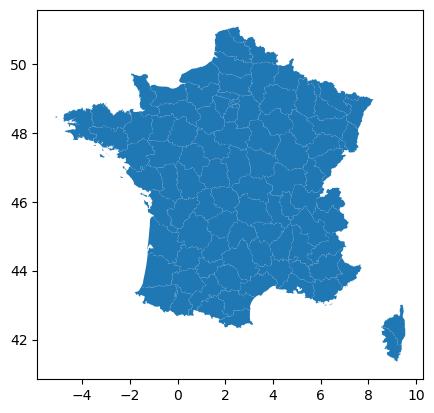

In [22]:
#Visualisation des contours
contours_dpt.plot()

On joint ensuite notre table départementale avec la table de contours départementaux. On note que les contours sont uniquement métropolitains et que la table obtenue ne concernera donc que les départements métropolitains. Etant donnée les défauts de données existant également pour la table nationale, on ne traitera que les département métropolitains.

In [23]:
#Préparation de la table 'contours_dpt'
contours_dpt = contours_dpt.rename(columns={'code': 'Département'})

In [24]:
# Inner join avec geopandas (gpd.merge)
dataframe_dep = dataframe.merge(
    contours_dpt,
    on=['Département'],
    how='inner'  # Conserve uniquement les lignes correspondantes
)

# Renommer les colonnes comme dans ton exemple
dataframe_dep = dataframe_dep.rename(columns={'geometry': 'Géométrie', 'nom': 'Nom'})

# Convertir en GeoDataFrame si nécessaire (si "contours_dpt" est déjà un GeoDataFrame, cette étape peut ne pas être nécessaire)
dataframe_dep = gpd.GeoDataFrame(dataframe_dep, geometry='Géométrie')

# Vérifier le résultat
print(dataframe_dep)


        Index                                      libellé index Département  \
0           1             Règlements de compte entre malfaiteurs          01   
1           2       Homicides pour voler et à l'occasion de vols          01   
2           3                     Homicides pour d'autres motifs          01   
3           4  Tentatives d'homicides pour voler et à l'occas...          01   
4           5          Tentatives homicides pour d'autres motifs          01   
...       ...                                                ...         ...   
277339    103  Infractions à l'exercice d'une profession règl...          95   
277340    104  Infractions au droit de l'urbanisme et de la c...          95   
277341    105                                   Fraudes fiscales          95   
277342    106            Autres délits économiques et financiers          95   
277343    107                                      Autres délits          95   

            Date  Nombre  Population   

### Calcul des taux de délinquance

''' 

https://mobile.interieur.gouv.fr/Interstats/Publications/Hors-collection/La-mesure-statistique-de-la-delinquance-AJ-Penal-Dalloz

https://www.interieur.gouv.fr/Media/SSMSI/Files/Interstats-Methode-N-3-La-premiere-generation-des-indicateurs-statistiques-des-crimes-et-delits-enregistres-par-la-police-et-la-gendarmerie-Octobre-2015/?nomobredirect=true

https://mobile.interieur.gouv.fr/Interstats/Actualites/Insecurite-et-delinquance-en-2023-bilan-statistique-et-atlas-departemental

'''

Les tableaux traités ici compote les 107 différentes catégories (index) d'infractions de "l'état 4001" enregistré par les forces de sécurité. De nature, fréquence et variables de comptage variées, agglomérer ces index en un seul indicateur de délinquance est susceptible de masquer des phénomènes délinquants important et en effet depuis 2012 le ministère de l'Intérieur a annoncé renoncé à l'utilisation d'indicateurs trop globaux. Aujourd'hui une dizaine d'indicateurs sont utilisés par le SSMSI dans leurs bilan statistique (le nombre peut varier selon la finesse de la typologie). On propose ici d'utiliser les 8 indicateurs principaux dénombrés dans le bilan statistique du SSMSI de 2013 ([téléchargable ici](https://mobile.interieur.gouv.fr/Interstats/Actualites/Insecurite-et-delinquance-en-2023-bilan-statistique-et-atlas-departemental)), à savoir les *homicides*, *tentatives d'homicides*, *coups et blessures volontaires*, *violences sexuelles*, *atteintes aux biens avec violence contre les personnes*, *atteintes aux biens sans violence contre les personnes*, *infractions à la législation sur les stupéfiants* et *escroqueries*.

Il est important de noter que les chiffres disponibles ici sont ceux de la criminalité observée et enregistrée qui reste un indicateur très imparfait. D'une part il n'est pas le nombre réel d'infractions mais n'est pas non plus égal à une proportion de ce nombre constante dans le temps. Des décisions politiques et de gestion (comme la politique du chiffre à partir de 2002, les variations de moyens alloués aux forces de sécurité) peuvent impacter la part de la criminalité enregistrée par rapport à la criminalité effective. D'autre part cette part observée n'est pas la même pour tous les types d'infractions. En particulier, les violences sexuelles étant très sous-déclarées et leur augmentation enregistrée étant quasiment uniquement dûe à la hausse des déclarations (au vue des enquêtes de victimation), on préférera  les traiter à part (ou ne pas les traiter par manque de temps).

Fort de ces remarques, on va dans cette section calculer les 8 indicateurs présentés à partir des 107 catégories à notre disposition. On utilise pour cela la section méthodologie du bilan de 2023 pour savoir quels index composent quelles catégories. On note que tous les index ne sont pas utilisés, certaines infractions ne correspondant pas ce qu'on considère usuellement comme phénomène délinquant (criminalité en col blanc, atteintes aux intérêts fondamentaux de la nation, fraude fiscale entre autres exemples).

In [25]:
# Mapping des indicateurs de délinquance et infractions associées 
mapping = {
    "Homicides": [1, 2, 3, 6, 51],
    "Tentatives d'homicides": [4, 5],
    "Coups et blessures volontaires": [7, 13],
    "Violences sexuelles": [45, 46, 47, 48, 49, 50],
    "Vols avec violence": [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    "Vols sans violence": [27, 28, 29, 30, 32, 42, 43, 34, 35, 36, 37, 38, 62, 63, 65, 66, 67, 68],
    "Stupéfiants": [56, 57, 58, 59],
    "Escroquerie": [91, 86, 89, 90, 92],
}

# Calcul des indicateurs et stockage dans les DateFrames

# Listes pour stocker les indicateurs
indicateurs_dep = []  # Niveau départemental
indicateurs_fr = []  # Niveau national

# Boucle qui permet de parcourir les DataFrames pour chaque indicateur
for indicateur, infractions in mapping.items():

    # On ne conserve que les lignes avec les infractions correspondant à l'indicateur
    dataframe_dep_filtre = dataframe_dep[dataframe_dep['Index'].isin(infractions)] 
    dataframe_nat_filtre = resultat[resultat['Index'].isin(infractions)] 

    # Somme des occurences d'infractions par zone géographique et par date
    somme_ind_dep = (dataframe_dep_filtre.groupby(["Date", "Département"])["Nombre"].sum()
        .reset_index() # Pour éviter que le groupby modifie l'index du DataFrame
    )
    somme_ind_nat = (dataframe_nat_filtre.groupby(["Date", "Zone"])["Nombre"].sum()
        .reset_index()
    )
    
    # Ajouter une colonne pour libeller les indicateurs
    somme_ind_dep["Indicateur"] = indicateur
    somme_ind_nat["Indicateur"] = indicateur

    # Ajouter les colonnes de libellé et de sommes au résultat
    indicateurs_dep.append(somme_ind_dep)
    indicateurs_fr.append(somme_ind_nat)

    # Population à date et zone géographique donnée 
    pop_dep_ind = (dataframe_dep_filtre.groupby(["Date", "Département"])["Population"].first())
    pop_nat_ind = (dataframe_nat_filtre.groupby(["Date", "Zone"])["Population"].first())

    # Contours géographiques à date et zone géographique donnée pour la base départementale
    geo_dep_ind = (dataframe_dep_filtre.groupby(["Date", "Département"])["Géométrie"].first())


# Combiner les résultats pour les indicateurs
df_indicateurs_dep = pd.concat(indicateurs_dep, ignore_index=True) 
df_indicateurs_nat = pd.concat(indicateurs_fr, ignore_index=True)

# Ajout des données de population départementale et les contours géographiques
df_indicateurs_dep = df_indicateurs_dep.merge(
    geo_dep_ind,
    on=["Date", "Département"],  
    how="left"                   
)

df_indicateurs_dep = df_indicateurs_dep.merge(
    pop_dep_ind,
    on=["Date", "Département"],  
    how="left"                   
)

df_indicateurs_nat = df_indicateurs_nat.merge(
    pop_nat_ind,
    on=["Date", "Zone"],  
    how="left"
)

# Réorganisation des colonnes 
df_indicateurs_dep = df_indicateurs_dep[["Date", "Département", "Indicateur", "Nombre", "Population", "Géométrie"]]
df_indicateurs_nat = df_indicateurs_nat[["Date", "Zone", "Indicateur", "Nombre", "Population"]]

# On supprime les lignes concernant la France Entière car nous avons trop de données manquantes sur ces zones
df_indicateurs_nat = df_indicateurs_nat.drop(df_indicateurs_nat[df_indicateurs_nat["Zone"] == "France_Entière"].index) 

# On crée une colonne avec les taux de délinquance pour chaque indicateurs en divisant les colonnes 'Nombre' et 'Population'
df_indicateurs_dep["Taux (%)"] = df_indicateurs_dep["Nombre"]*100/df_indicateurs_dep["Population"]

# On avait eu un problème pour la division au niveau national, on vérifie et corrige les problèmes de types de données
print(df_indicateurs_nat.dtypes)
df_indicateurs_nat["Population"] = pd.to_numeric(df_indicateurs_nat["Population"], errors='coerce')
print(df_indicateurs_nat.dtypes)

# On peut maintenant créer la colonne de taux dans la base de données nationale
df_indicateurs_nat["Taux (%)"] = df_indicateurs_nat["Nombre"]*100/df_indicateurs_nat["Population"]/1000 # La population est en milliers d'habitant

# Affichage les résultats
print(df_indicateurs_dep)
print(df_indicateurs_nat)

Date           object
Zone           object
Indicateur     object
Nombre        float64
Population     object
dtype: object
Date           object
Zone           object
Indicateur     object
Nombre        float64
Population      int64
dtype: object
           Date Département   Indicateur  Nombre  Population  \
0      _1996_01          01    Homicides     0.0      499310   
1      _1996_01          02    Homicides     1.0      538017   
2      _1996_01          03    Homicides     0.0      349376   
3      _1996_01          04    Homicides     0.0      137453   
4      _1996_01          05    Homicides     0.0      118526   
...         ...         ...          ...     ...         ...   
20731  _2022_01          91  Escroquerie   659.0     1319836   
20732  _2022_01          92  Escroquerie  1634.0     1641277   
20733  _2022_01          93  Escroquerie   898.0     1679240   
20734  _2022_01          94  Escroquerie   789.0     1421887   
20735  _2022_01          95  Escroquerie   686.0

In [26]:
# Ajouter la colonne année et mois pour davantage de clarté
df_indicateurs_dep[['Année', 'Mois']] = df_indicateurs_dep['Date'].str.extract(r'_(\d{4})_(\d{2})')
df_indicateurs_nat[['Année', 'Mois']] = df_indicateurs_nat['Date'].str.extract(r'_(\d{4})_(\d{2})')

print(df_indicateurs_nat)

          Date          Zone   Indicateur   Nombre  Population  Taux (%)  \
1     _1996_01  France_Métro    Homicides    115.0       57936  0.000198   
3     _1996_02  France_Métro    Homicides    108.0       57943  0.000186   
5     _1996_03  France_Métro    Homicides    128.0       57951  0.000221   
7     _1996_04  France_Métro    Homicides    119.0       57963  0.000205   
9     _1996_05  France_Métro    Homicides    112.0       57976  0.000193   
...        ...           ...          ...      ...         ...       ...   
5111  _2022_04  France_Métro  Escroquerie  32572.0       65756  0.049535   
5113  _2022_05  France_Métro  Escroquerie  34951.0       65770  0.053141   
5115  _2022_06  France_Métro  Escroquerie  34619.0       65794  0.052617   
5117  _2022_07  France_Métro  Escroquerie  34042.0       65820  0.051720   
5119  _2022_08  France_Métro  Escroquerie  34997.0       65843  0.053152   

     Année Mois  
1     1996   01  
3     1996   02  
5     1996   03  
7     1996   04

In [27]:
# Convertir les colonnes 'Date' au format _YYYY_MM en un objet datetime

if not pd.api.types.is_datetime64_any_dtype(df_indicateurs_dep['Date']):
    df_indicateurs_dep['Date'] = pd.to_datetime(df_indicateurs_dep['Date'].str.extract(r'_(\d{4})_(\d{2})')[0] + '-' +
                             df_indicateurs_dep['Date'].str.extract(r'_(\d{4})_(\d{2})')[1], format='%Y-%m')

if not pd.api.types.is_datetime64_any_dtype(df_indicateurs_nat['Date']):
    df_indicateurs_nat['Date'] = pd.to_datetime(df_indicateurs_nat['Date'].str.extract(r'_(\d{4})_(\d{2})')[0] + '-' +
                             df_indicateurs_nat['Date'].str.extract(r'_(\d{4})_(\d{2})')[1], format='%Y-%m')

print(df_indicateurs_dep)
print(df_indicateurs_nat)

            Date Département   Indicateur  Nombre  Population  \
0     1996-01-01          01    Homicides     0.0      499310   
1     1996-01-01          02    Homicides     1.0      538017   
2     1996-01-01          03    Homicides     0.0      349376   
3     1996-01-01          04    Homicides     0.0      137453   
4     1996-01-01          05    Homicides     0.0      118526   
...          ...         ...          ...     ...         ...   
20731 2022-01-01          91  Escroquerie   659.0     1319836   
20732 2022-01-01          92  Escroquerie  1634.0     1641277   
20733 2022-01-01          93  Escroquerie   898.0     1679240   
20734 2022-01-01          94  Escroquerie   789.0     1421887   
20735 2022-01-01          95  Escroquerie   686.0     1263170   

                                               Géométrie  Taux (%) Année Mois  
0      POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  0.000000  1996   01  
1      POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  0

On voulait sauvegarder les deux bases mais malheureusement elles sont trop volumineuses pour être push. Dommage...

### Partie de stat desc il faudra la déplacer probablement

In [28]:
# Définir la charte graphique pour qu'elle soit uniforme entre les différentes stats descriptives (on veut que nos graphiques matchent avec nos cartes)
charte_graphique = {
    "Vols sans violence": "Magenta",
    "Escroquerie": "Green",
    "Coups et blessures volontaires": "Cyan",
    "Stupéfiants": "Pink",
    "Vols avec violence": "Red",
    "Violences sexuelles" : "Orange",
    "Tentatives d'homicides" : "Blue",
    "Homicides" : "Purple"
}

Ajoutons une colonne donnant les taux relatifs dns notre dataframe df_indicateurs_nat pour nous permettre d'évaluer des variations relatives et pas seulement en valeur brute.

In [29]:
# Trier les données par indicateur et par date
df_indicateurs_nat = df_indicateurs_nat.sort_values(by=['Indicateur', 'Date']).reset_index(drop=True)

# Normaliser les valeurs à 1 pour la première valeur de chaque indicateur
df_indicateurs_nat['Taux relatif'] = df_indicateurs_nat.groupby('Indicateur')['Taux (%)'].transform(lambda x: x / x.iloc[0])

In [30]:
#Version de la fonction de tracage où on peut appliquer une échelle logarithmique ou lisser si on le veut (argument à appeler quand on appliquer la fonction)

def tracer_evolution_taux(
    df, charte_graphique, taux="Taux (%)", title="Évolution des taux d'infractions", 
    xlabel="Date", ylabel="Taux (%)", use_log_scale=False, smooth=False, window_size=100, time_period=[]
):
    """
    Trace l'évolution des taux pour une liste d'indicateurs, avec option de lissage.

    Args:
        df (pd.DataFrame): Le dataframe contenant les données.
        charte_graphique (dict): Dictionnaire {nom_indicateur: couleur}.
        taux (str): Colonne du dataframe contenant les valeurs à tracer.
        title (str): Titre du graphique.
        xlabel (str): Label de l'axe des x.
        ylabel (str): Label de l'axe des y.
        use_log_scale (bool): Utiliser une échelle logarithmique sur l'axe des y.
        smooth (bool): Lisser les courbes avec une moyenne mobile.
        window_size (int): Taille de la fenêtre pour la moyenne mobile.
    """
    plt.figure(figsize=(14, 7))
    
    for indicateur, couleur in charte_graphique.items():
        # Filtrer les données pour l'indicateur
        filtre = df['Indicateur'] == indicateur
        
        # Appliquer borne temporelle si demandé :
        if time_period != []:
        # Appliquer d'abord le filtre sur l'indicateur, puis appliquer la borne temporelle
            dates = df.loc[(df['Date'] >= time_period[0]) & (df['Date'] <= time_period[1]) & filtre, 'Date']
            valeurs = df.loc[(df['Date'] >= time_period[0]) & (df['Date'] <= time_period[1]) & filtre, taux]
        else:
        # Si pas de borne temporelle, appliquer seulement le filtre sur l'indicateur
            dates = df.loc[filtre, 'Date']
            valeurs = df.loc[filtre, taux]

        # Appliquer un lissage si demandé
        if smooth:
            valeurs = valeurs.rolling(window=window_size, center=True, min_periods=1).mean()
        
        # Tracer la courbe
        plt.plot(dates, valeurs, color=couleur, linewidth=0.8, label=indicateur)
    
    # Ajouter des titres, légendes, et la grille
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Appliquer une échelle logarithmique si demandé
    if use_log_scale:
        plt.yscale('log')

    # Ajustement et affichage
    plt.tight_layout()
    plt.show()


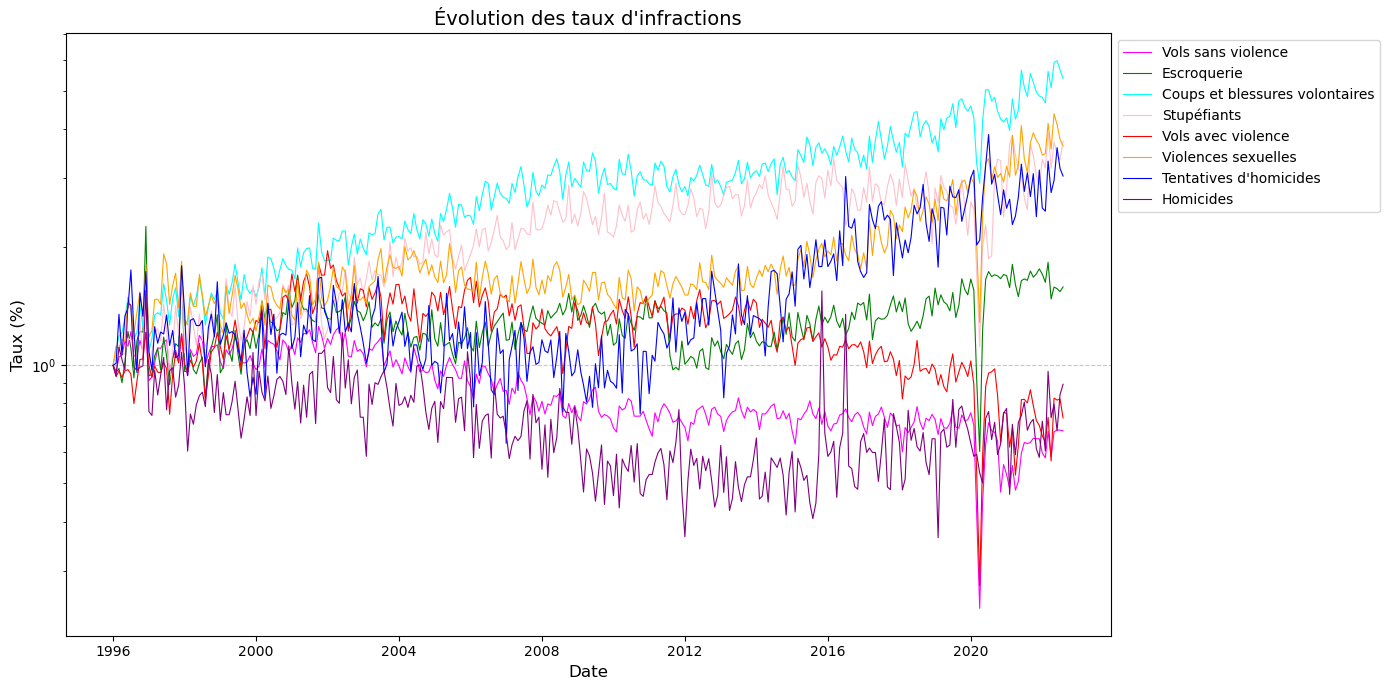

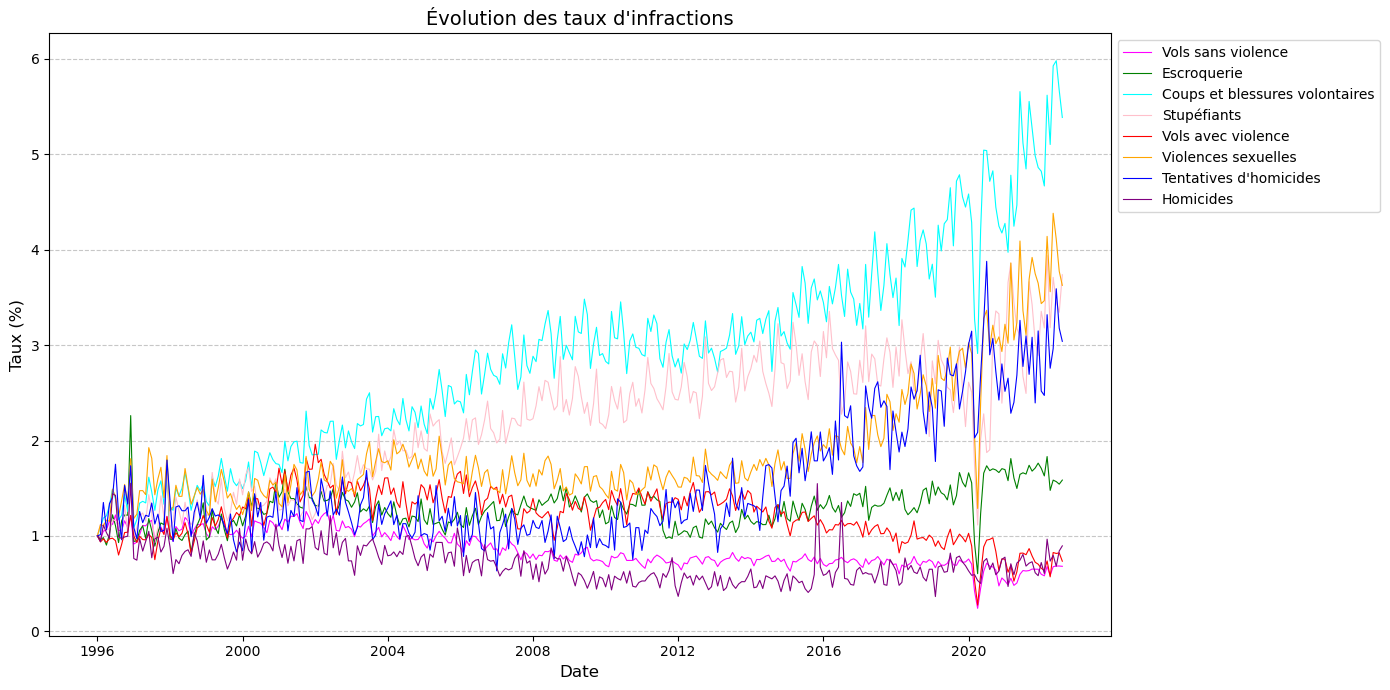

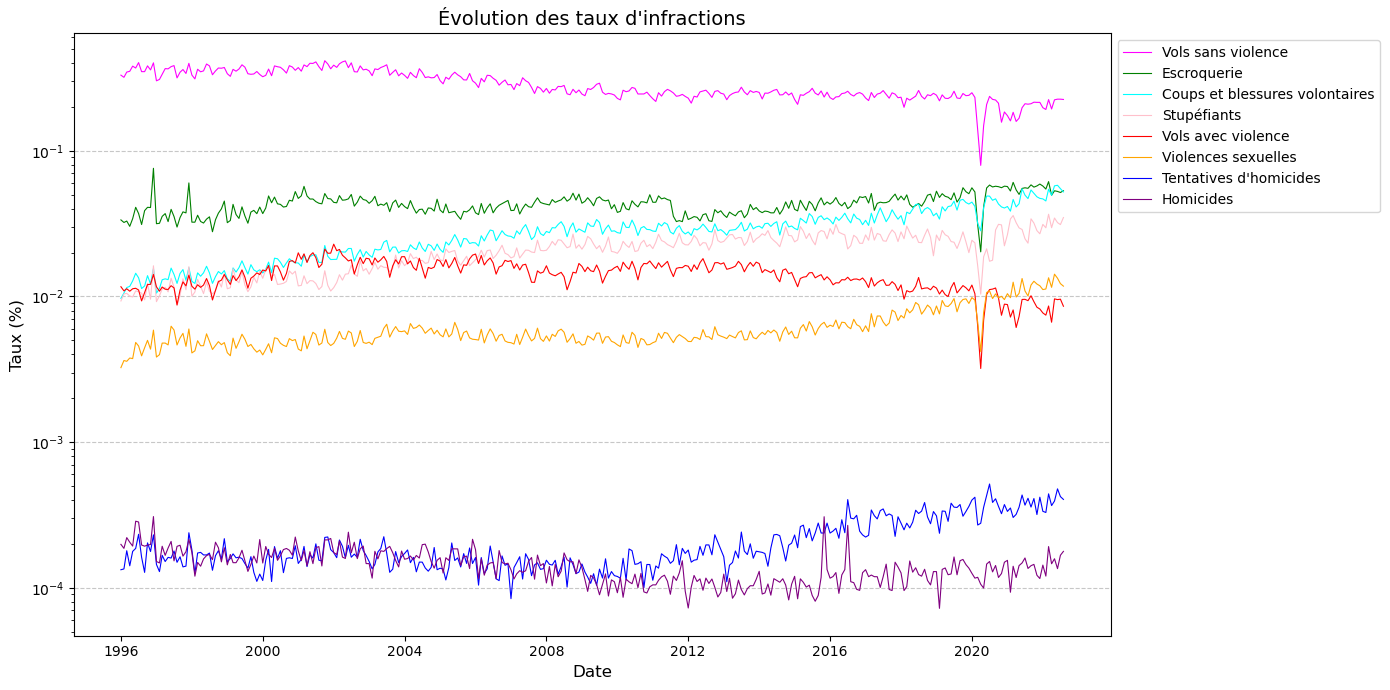

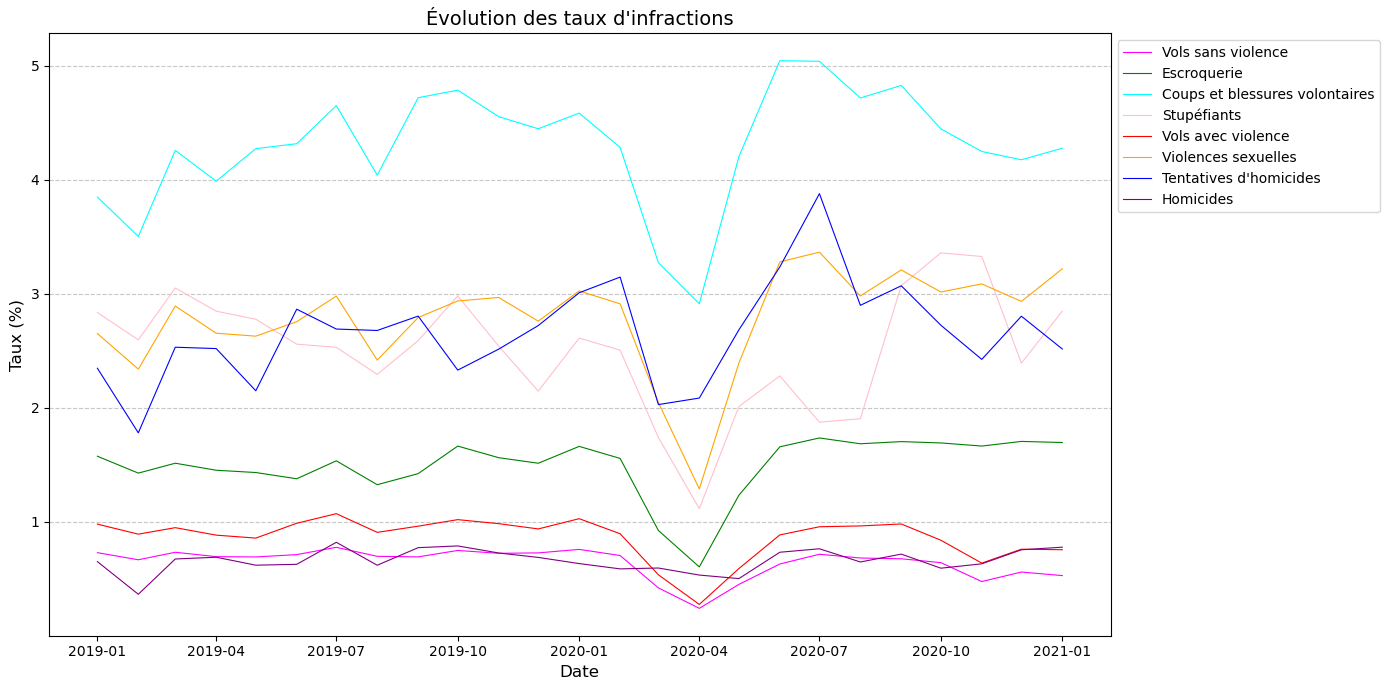

In [31]:
# Exemples d'utilisation
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux relatif", use_log_scale = True, time_period=[])
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux relatif")
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux (%)", use_log_scale = True)
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux relatif", use_log_scale = False, smooth = False, time_period=["2019-01-01", "2021-01-01"])

On observe pendant la période de la pandémie du Covid19 une baisse significative sur chaque (ou presque) indicateur de délinquance ce qui semble plutôt intuitivement cohérent.

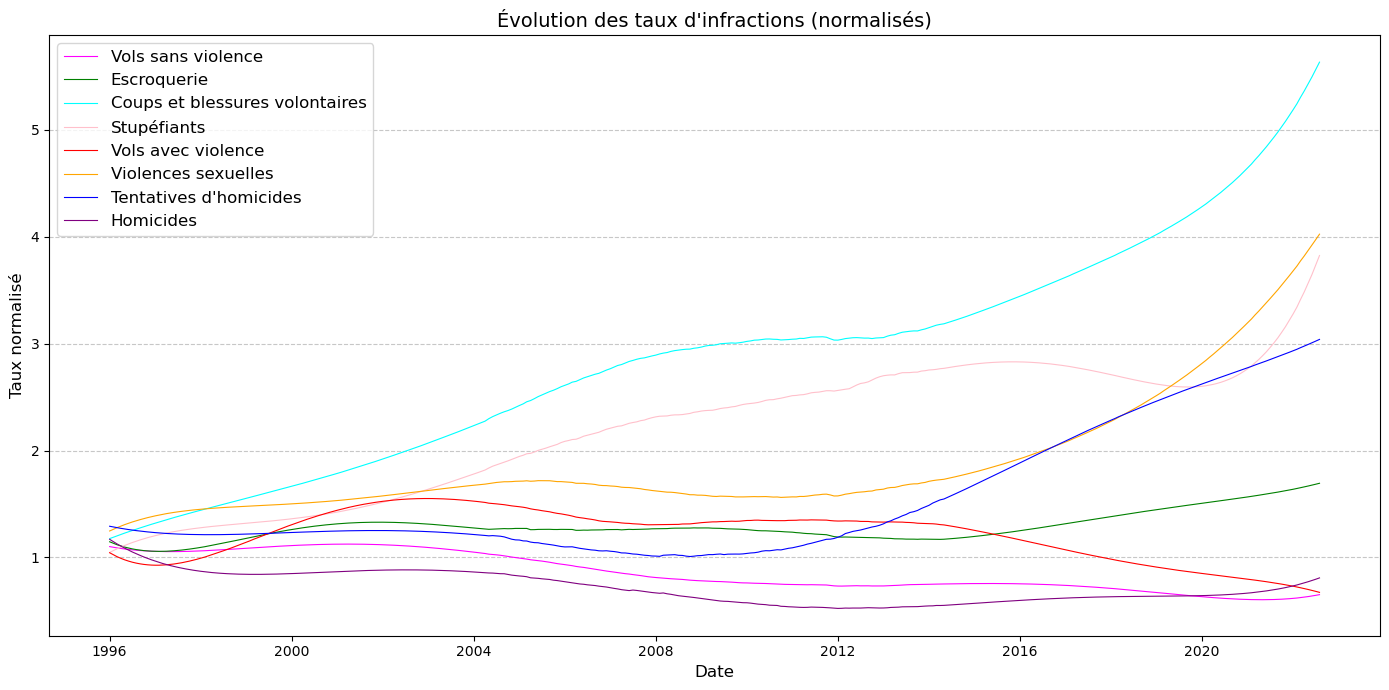

In [32]:
from scipy.signal import savgol_filter

def tracer_evolution_taux_relatif_lisse(df, charte_graphique, title="Évolution des taux d'infractions (normalisés)", xlabel="Date", ylabel="Taux normalisé"):
    """
    Trace l'évolution des taux normalisés pour une liste d'indicateurs.

    Args:
        df (pd.DataFrame): Le dataframe contenant les données.
        charte_graphique (dict): Dictionnaire {nom_indicateur: couleur}.
        title (str): Titre du graphique.
        xlabel (str): Label de l'axe des x.
        ylabel (str): Label de l'axe des y.
    """

    window_length = 200
    polyorder = 5

    plt.figure(figsize=(14, 7))

    for indicateur, couleur in charte_graphique.items():
        # Extraire les données pour l'indicateur
        filtre = df['Indicateur'] == indicateur
        data_indicateur = df.loc[filtre].copy()


        # Normaliser les valeurs en divisant par la valeur initiale (1996)
        valeur_initiale = data_indicateur.iloc[0]['Taux (%)']
        data_indicateur['Taux normalisé'] = data_indicateur['Taux (%)'] / valeur_initiale
        #data_indicateur = data_indicateur[(data_indicateur['Date'] >= "2019-01-01") & (data_indicateur['Date'] <= "2021-01-01")]
        # Appliquer un lissage aux taux relatifs avec Savitzky-Golay
        if len(data_indicateur) >= window_length:
            taux_lisse = savgol_filter(data_indicateur['Taux relatif'], window_length=window_length, polyorder=polyorder)
        else:
            taux_lisse = data_indicateur['Taux relatif']  # Pas de lissage si pas assez de points
        # Tracer la courbe
        plt.plot(
            data_indicateur['Date'], 
            taux_lisse, 
            color=couleur, 
            linewidth=0.8, 
            label=indicateur
        )

    # Ajouter des titres, légendes et la grille
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajustement et affichage
    plt.tight_layout()
    plt.show()

tracer_evolution_taux_relatif_lisse(df_indicateurs_nat, charte_graphique)

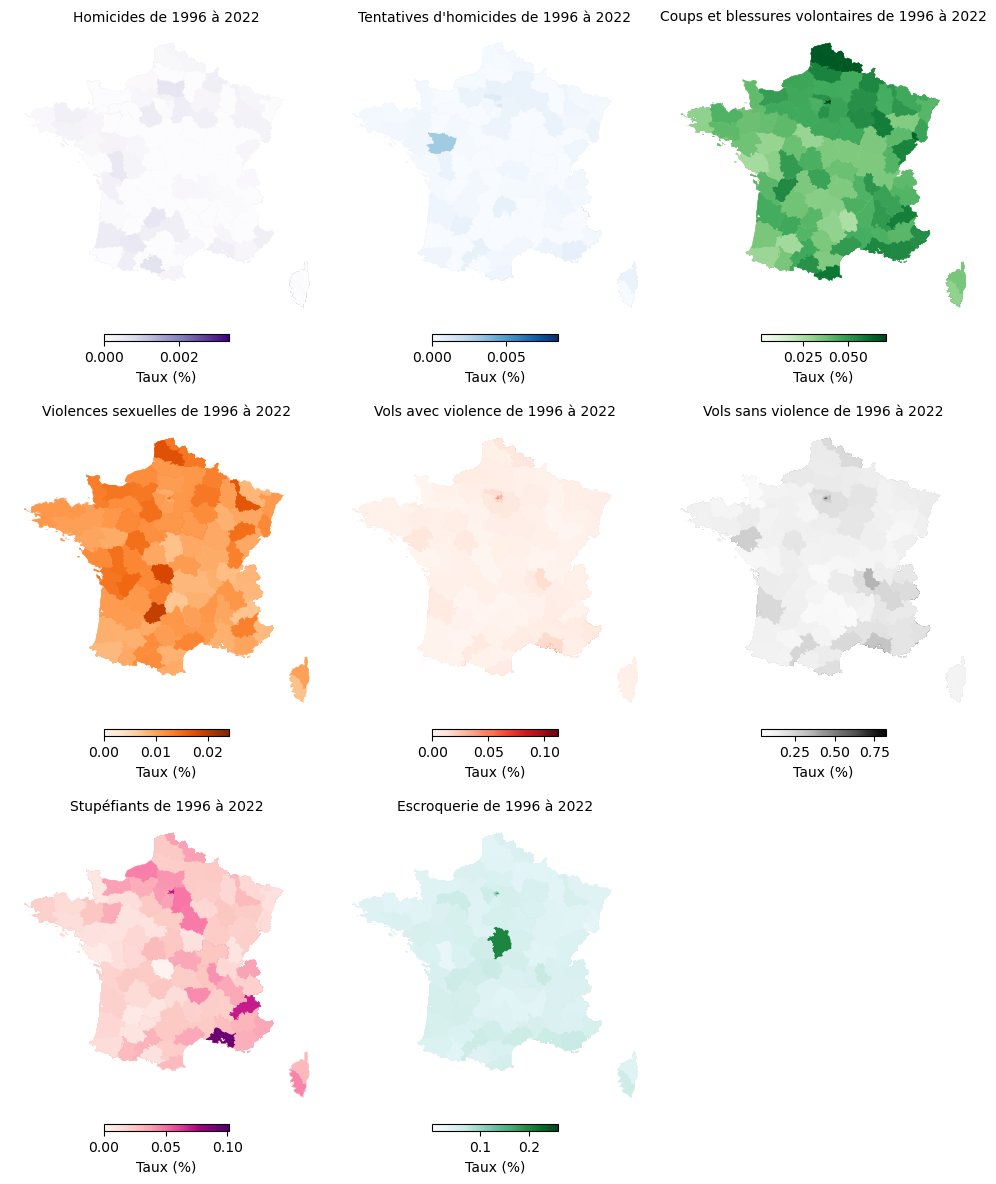

In [33]:
# Définir la colonne géométrique active
df_indicateurs_dep = df_indicateurs_dep.set_geometry("Géométrie")

indicateurs = list(mapping.keys())  

# Calcul du nombre total de figures
total_figures = len(indicateurs)

nuance = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'Greys', 'RdPu', 'BuGn']

# Créer des sous-graphiques
fig, axes = plt.subplots(3, 3, figsize=(10, 12))  # Augmenter la hauteur totale
axes = axes.flatten()

i = 0
for idx, indicateur in enumerate(indicateurs):
    # Tracer chaque indicateur
    df_indicateurs_dep[df_indicateurs_dep['Indicateur'] == indicateur].plot(
        column='Taux (%)',
        cmap=nuance[i],
        legend=True,
        ax=axes[idx],
        missing_kwds={"color": "lightgrey", "label": "Données manquantes"},
        legend_kwds={
            'shrink': 0.4,  
            'label': 'Taux (%)',  
            'orientation': 'horizontal',  
            'fraction': 0.04,  
            'pad': 0.04  
        }
    )

    # Ajuster le titre
    axes[idx].set_title(indicateur + " de 1996 à 2022", fontsize=10)
    axes[idx].axis('off')  # Masquer les axes

    # Ajuster le rapport d'aspect
    axes[idx].set_aspect(1.4)  # Étendre verticalement
    i += 1
    
# Supprimer les cadres inutilisés
for idx in range(total_figures, len(axes)):
    fig.delaxes(axes[idx])

# Ajuster les espacements
plt.tight_layout()
plt.show()


In [34]:
# Essai carte interractive Anh Linh

#Import nécessaire, certain ont déjà été fait mais on nettoiera en temps voulu
import pandas as pd
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [35]:
%pip install nbformat 

Note: you may need to restart the kernel to use updated packages.


In [36]:
# Sélection d'une année focus pour le moment 
année = '1996'
df_sected = df_indicateurs_dep[(df_indicateurs_dep['Année']== année )&(df_indicateurs_dep['Indicateur']== 'Homicides')]

print(df_sected)

         Date Département Indicateur  Nombre  Population  \
0  1996-01-01          01  Homicides     0.0      499310   
1  1996-01-01          02  Homicides     1.0      538017   
2  1996-01-01          03  Homicides     0.0      349376   
3  1996-01-01          04  Homicides     0.0      137453   
4  1996-01-01          05  Homicides     0.0      118526   
..        ...         ...        ...     ...         ...   
91 1996-01-01          91  Homicides     2.0     1131399   
92 1996-01-01          92  Homicides     3.0     1406949   
93 1996-01-01          93  Homicides     7.0     1389668   
94 1996-01-01          94  Homicides     1.0     1221145   
95 1996-01-01          95  Homicides     6.0     1097809   

                                            Géométrie  Taux (%) Année Mois  
0   POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  0.000000  1996   01  
1   POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  0.000186  1996   01  
2   POLYGON ((3.03207 46.79491, 3.03424 46.7908,

In [37]:
import geopandas as gpd
from shapely.geometry import shape

# Supposons que df_indicateurs_dep contient une colonne 'Géométrie' avec des objets géométriques (par exemple, des objets shapely ou GeoJSON)
# Convertir les géométries de la colonne 'Géométrie' en objets géométriques shapely
df_sected['geometry'] = df_sected['Géométrie'].apply(lambda x: shape(x))

# Créer un GeoDataFrame à partir de ce DataFrame
gdf_sected = gpd.GeoDataFrame(df_sected, geometry='geometry')

# Assurez-vous que le CRS est défini - ici j'utilise EPSG:4326 pour les coordonnées géographiques (latitude/longitude)
gdf_sected = gdf_sected.set_crs("EPSG:4326", allow_override=True)

# Afficher le GeoDataFrame pour vérifier
print(gdf_sected)


         Date Département Indicateur  Nombre  Population  \
0  1996-01-01          01  Homicides     0.0      499310   
1  1996-01-01          02  Homicides     1.0      538017   
2  1996-01-01          03  Homicides     0.0      349376   
3  1996-01-01          04  Homicides     0.0      137453   
4  1996-01-01          05  Homicides     0.0      118526   
..        ...         ...        ...     ...         ...   
91 1996-01-01          91  Homicides     2.0     1131399   
92 1996-01-01          92  Homicides     3.0     1406949   
93 1996-01-01          93  Homicides     7.0     1389668   
94 1996-01-01          94  Homicides     1.0     1221145   
95 1996-01-01          95  Homicides     6.0     1097809   

                                            Géométrie  Taux (%) Année Mois  \
0   POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  0.000000  1996   01   
1   POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  0.000186  1996   01   
2   POLYGON ((3.03207 46.79491, 3.03424 46.79

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
print(gdf_sected.crs)

EPSG:4326


In [39]:
# Choix de couleur
scl = [[0.0, '#ffffff'],[0.2, '#ff9999'],[0.4, '#ff4d4d'], 
       [0.6, '#ff1a1a'],[0.8, '#cc0000'],[1.0, '#4d0000']] # reds

# Objet à ploter
data = [dict(
       type='choropleth',  # Type de graphique choroplèthe
       geojson=gdf_sected['Géométrie'].__geo_interface__,  # Colonne Géométrie convertie en GeoJSON
       locations=gdf_sected['Département'],  # Identifiants des départements (colonne)
       z=gdf_sected['Taux (%)'],  # Données utilisées pour la coloration
       locationmode='geojson-id',  # Mode pour correspondre aux identifiants GeoJSON
       text=df_sected['Département'],  # Texte affiché au survol (par exemple le nom des départements)
       colorscale=scl,  # Palette de couleurs
       colorbar=dict(
              title="Taux d'homicides"  # Titre de la barre de couleur
       ),
       marker=dict(
              line=dict(
              color='rgb(255,255,255)',  # Couleur des lignes de séparation
              width=2  # Largeur des lignes
              )
       )
       )]


In [40]:
layout = dict(
    title="Carte des départements français",  # Titre de la carte
    geo=dict(
        scope='europe',  # Ajustement pour centrer sur l'Europe (incluant la France)
        projection=dict(
            type='mercator'  # Projection plane adaptée à votre GeoDataFrame
        )
    )
)

In [41]:
fig=dict(data=data, layout=layout)

In [43]:
#plotly.offline.iplot(fig)


In [44]:
from plotly.offline import plot

#le mieux que j'arrive à faire c'est avoir une carte pas centrée sur la france et qu'on peut ouvrir que en html
fig = dict(data=data, layout=layout)
plot(fig, filename='mapbis.html')

'mapbis.html'

In [45]:

"""
pip install ipywidgets
"""

'\npip install ipywidgets\n'

In [46]:
'''
import folium
from ipywidgets import interact

def create_map(indicateur, annee):
    # Filtrer les données selon l'indicateur et l'année choisis
    data_filtered = df_indicateurs_dep[(df_indicateurs_dep['Indicateur'] == indicateur) & (df_indicateurs_dep['Année'] == annee)]

    # Créer une carte centrée sur la France
    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6, control_scale=True)

    # Ajouter les données filtrées sur la carte avec un choropleth
    choropleth = folium.Choropleth(
        geo_data=data_filtered,
        data=data_filtered,
        columns=['Département', 'Taux (%)'],
        key_on='feature.id',  # Ajustez si nécessaire en fonction de votre format géométrique
        fill_color='Reds',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=f'Taux (%) - {indicateur} ({annee})'
    )
    choropleth.add_to(m)

    # Ajouter des popups pour chaque département
    for _, row in data_filtered.iterrows():
        folium.Popup(f"{row['Département']}: {row['Taux (%)']}%").add_to(folium.GeoJson(row['Géométrie']))

    # Ajouter une barre de contrôle pour basculer les couches si besoin
    folium.LayerControl().add_to(m)

    return m

# Créer des widgets pour sélectionner l'indicateur et l'année
indicateurs = df_indicateurs_dep['Indicateur'].unique()
annees = df_indicateurs_dep['Année'].unique()

# Utiliser `interact` pour afficher une carte dynamique
interact(create_map, indicateur=indicateurs, annee=annees)
'''


'\nimport folium\nfrom ipywidgets import interact\n\ndef create_map(indicateur, annee):\n    # Filtrer les données selon l\'indicateur et l\'année choisis\n    data_filtered = df_indicateurs_dep[(df_indicateurs_dep[\'Indicateur\'] == indicateur) & (df_indicateurs_dep[\'Année\'] == annee)]\n\n    # Créer une carte centrée sur la France\n    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6, control_scale=True)\n\n    # Ajouter les données filtrées sur la carte avec un choropleth\n    choropleth = folium.Choropleth(\n        geo_data=data_filtered,\n        data=data_filtered,\n        columns=[\'Département\', \'Taux (%)\'],\n        key_on=\'feature.id\',  # Ajustez si nécessaire en fonction de votre format géométrique\n        fill_color=\'Reds\',\n        fill_opacity=0.7,\n        line_opacity=0.2,\n        legend_name=f\'Taux (%) - {indicateur} ({annee})\'\n    )\n    choropleth.add_to(m)\n\n    # Ajouter des popups pour chaque département\n    for _, row in data_filtered

In [47]:

df_indicateurs_dep = df_indicateurs_dep.set_crs(epsg=2154, allow_override=True)


In [48]:

df_indicateurs_dep['Année'] = df_indicateurs_dep['Année'].astype(str)
df_indicateurs_dep['Date'] = df_indicateurs_dep['Date'].astype(str)

On a essayé mais on n'a pas réussi à afficher une carte animée de la France donc on a décidé d'implémenter une fonction qui permet d'obtenir les cartes de répartition des taux d'un indicateur pour chaque année entre 1996 et 2022 pour en constater l'évolution.

In [49]:
import geopandas as gpd
import matplotlib as mpl

def évolution_indicateur(indicateur):
    # Définir le nombre de cartes par ligne
    cartes_par_ligne = 7
    
    # Calculer le nombre de lignes nécessaires
    total_annees = 2022 - 1996 + 1
    lignes = (total_annees // cartes_par_ligne) + (1 if total_annees % cartes_par_ligne != 0 else 0)
    
    # Créer une figure avec une taille ajustée pour les petites cartes
    fig, axes = plt.subplots(nrows=lignes, ncols=cartes_par_ligne, figsize=(12, lignes * 2))
    
    # Aplatir la liste des axes pour y accéder plus facilement
    axes = axes.flatten()

    # Créer une liste pour stocker les valeurs des taux pour l'échelle partagée
    taux_values = []

    # Parcours des années de 1996 à 2022
    for idx, annee in enumerate(range(1996, 2023)):
        # Filtrer les données pour l'indicateur et l'année en cours
        df_filtre = df_indicateurs_dep[(df_indicateurs_dep['Année'] == str(annee)) & (df_indicateurs_dep['Indicateur'] == indicateur)]
        
        # Créer un GeoDataFrame avec la colonne 'Géométrie'
        gdf = gpd.GeoDataFrame(df_filtre, geometry='Géométrie')
        
        # Ajouter les valeurs des taux dans la liste pour l'échelle partagée
        taux_values.extend(gdf['Taux (%)'].dropna().tolist())
        
        # Vérifier si le GeoDataFrame n'est pas vide
        if not gdf.empty:
            # Afficher la carte avec le taux (%) sur l'axe correspondant
            gdf.plot(column='Taux (%)', cmap='Reds', ax=axes[idx], legend=False)
            
            # Titre de la carte
            axes[idx].set_title(f"{indicateur} - {annee}", fontsize=6)
            axes[idx].axis("off")  # Enlever les axes
            axes[idx].set_aspect(1.4)
        else:
            axes[idx].axis("off")  # Si aucune donnée, ne pas afficher d'axes

    # Créer un ScalarMappable pour la légende partagée
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=mpl.colors.Normalize(vmin=min(taux_values), vmax=max(taux_values)))
    sm.set_array([])  # Nécessaire pour la légende
    
    # Ajouter la légende commune à la dernière case vide (celle qui reste vide)
    cbar = fig.colorbar(sm, ax=axes[-1], orientation='horizontal', fraction=0.045, pad=0.06, label="Taux (%)")
    
    # Supprimer le contour de la dernière case où la légende est placée
    axes[-1].axis("off")
    
    # Ajuster l'espacement pour les sous-graphes et la légende
    plt.subplots_adjust(hspace=0.1, bottom=0, top=0.6)  # Ajuster l'espacement vertical et l'espacement en bas
    
    # Afficher la figure
    plt.show()


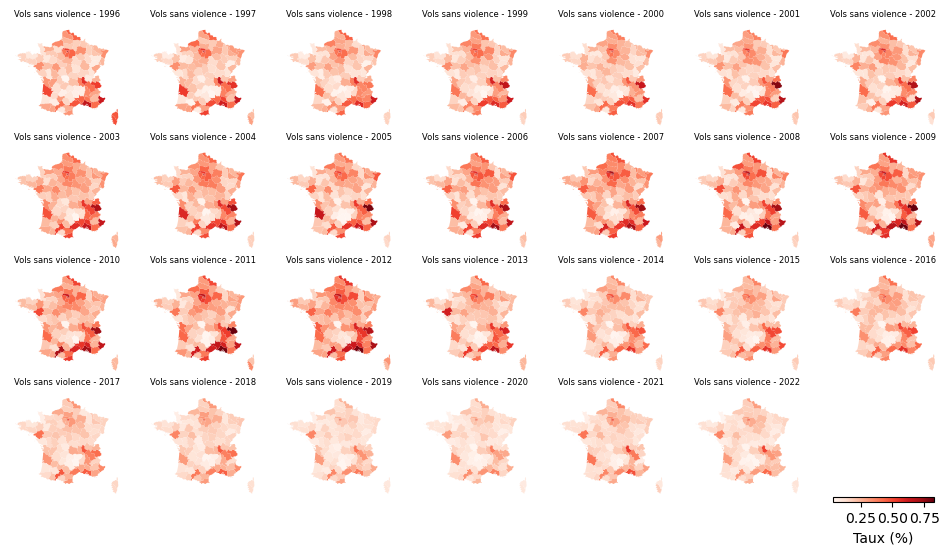

In [50]:
évolution_indicateur("Vols sans violence")

In [51]:
plt.ioff()  # Désactive le mode interactif

In [59]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import os

def evolution_indicateur_animation(indicateur):
    # Préparer la figure et l'axe
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Créer une liste des années de 1996 à 2022
    annees = list(range(1996, 2023))
    
    # Fonction d'initialisation pour l'animation
    def init():
        ax.clear()
        ax.set_title(f"{indicateur} - Initialisation")
        ax.axis("off")
        return []
    
    # Fonction de mise à jour pour chaque frame de l'animation
    def update(frame):
        ax.clear()
        annee = annees[frame]
        
        # Filtrer les données pour l'indicateur et l'année en cours
        df_filtre = df_indicateurs_dep[(df_indicateurs_dep['Année'] == str(annee)) & (df_indicateurs_dep['Indicateur'] == indicateur)]
        
        # Créer un GeoDataFrame avec la colonne 'Géométrie'
        gdf = gpd.GeoDataFrame(df_filtre, geometry='Géométrie')
        
        # Vérifier si le GeoDataFrame n'est pas vide
        if not gdf.empty:
            # Calculer les limites de couleur
            vmin = df_indicateurs_dep[df_indicateurs_dep['Indicateur'] == indicateur]['Taux (%)'].min()
            vmax = df_indicateurs_dep[df_indicateurs_dep['Indicateur'] == indicateur]['Taux (%)'].max()
            
            # Tracer la carte
            gdf.plot(column='Taux (%)', 
                     cmap='Reds', 
                     ax=ax, 
                     legend=False,
                     vmin=vmin,
                     vmax=vmax,
                     edgecolor='0.8',
                     linewidth=0.8)
            
            # Titre de la carte
            ax.set_title(f"{indicateur} - {annee}")
        
        ax.axis("off")
        ax.set_aspect('equal')
        
        return []
    
    # Créer l'animation
    anim = animation.FuncAnimation(fig, 
                                   update, 
                                   init_func=init,
                                   frames=len(annees), 
                                   interval=500,  # 500 ms entre chaque frame
                                   blit=True)
    
    # Ajouter une barre de couleur
    vmin = df_indicateurs_dep[df_indicateurs_dep['Indicateur'] == indicateur]['Taux (%)'].min()
    vmax = df_indicateurs_dep[df_indicateurs_dep['Indicateur'] == indicateur]['Taux (%)'].max()
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=colors.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.036, pad=0.1, label="Taux (%)")
    
    # Sauvegarder l'animation au format GIF
    # Crée un dossier 'animations' s'il n'existe pas
    os.makedirs('animations', exist_ok=True)
    
    # Chemin de sauvegarde
    save_path = f'animations/evolution_{indicateur.replace(" ", "_")}.gif'
    
    # Sauvegarde en GIF (plus compatible)
    anim.save(save_path, writer='pillow', fps=2)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Animation sauvegardée dans {save_path}")
    
    return anim

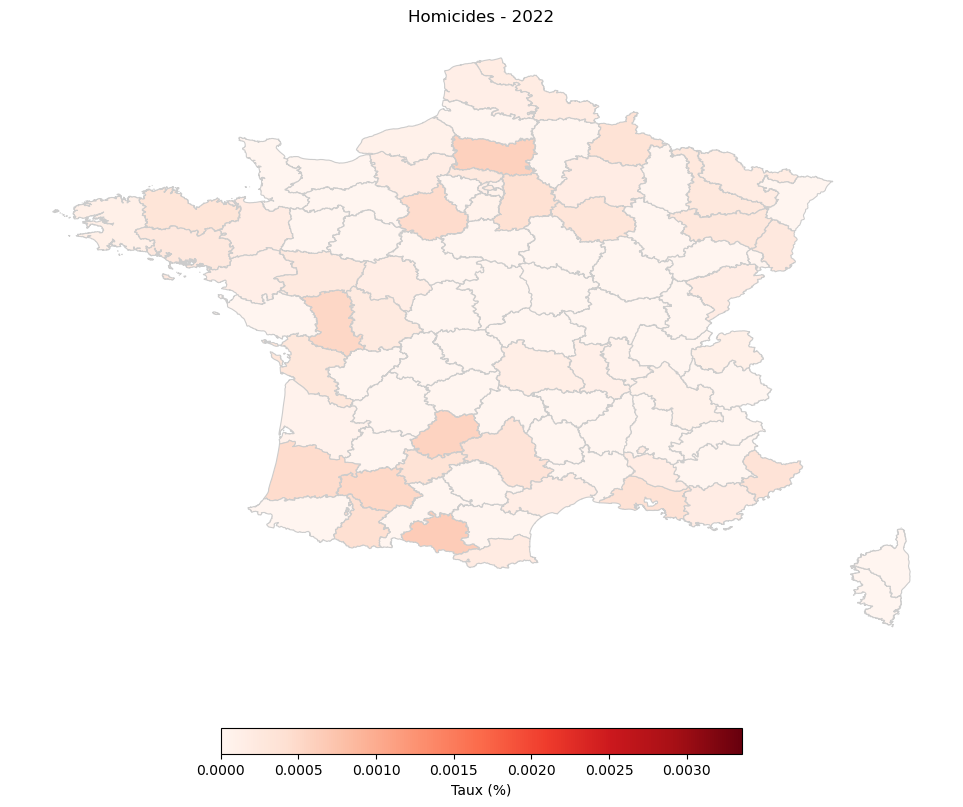

Animation sauvegardée dans animations/evolution_Homicides.gif


In [60]:
evolution_indicateur_animation('Homicides')

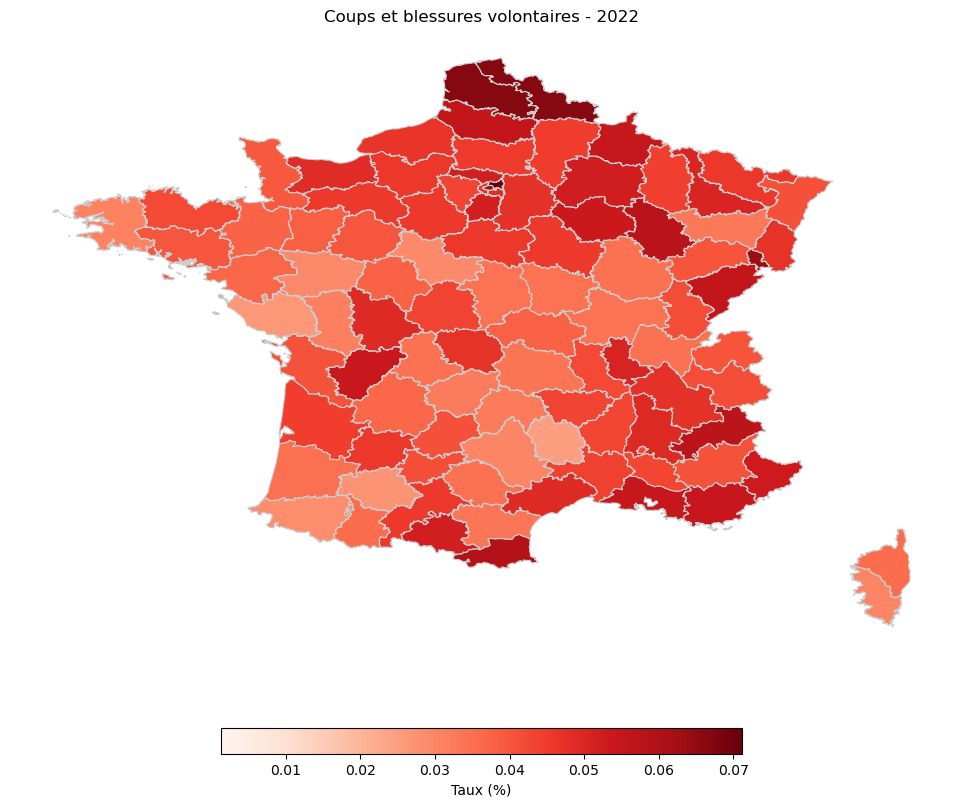

Animation sauvegardée dans animations/evolution_Coups_et_blessures_volontaires.gif


In [54]:
evolution_indicateur_animation('Coups et blessures volontaires')

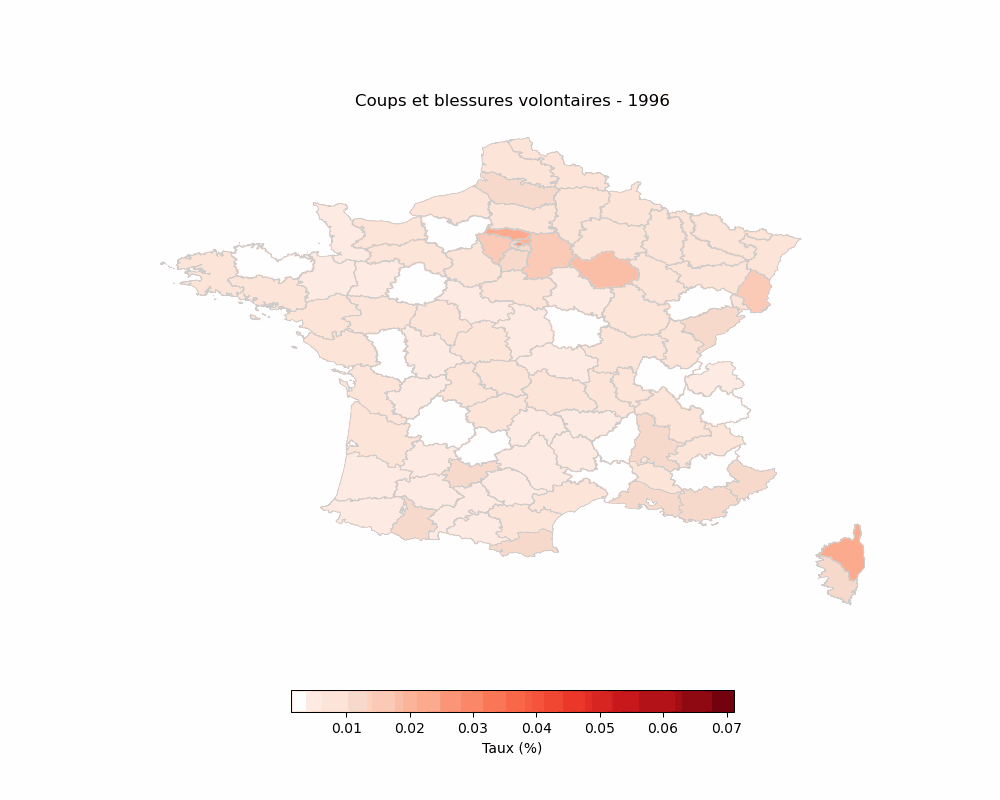

In [61]:
from IPython.display import Image, display

# Spécifiez le chemin vers votre fichier GIF
gif_path = "/home/onyxia/work/Python-pour-la-data-science-2A/data/animations/evolution_Coups_et_blessures_volontaires.gif"

# Utilisez IPython.display pour afficher le GIF
display(Image(filename=gif_path))